# Minimal Features

In [1]:
from BeerMe.Pipeline import *

In [2]:
df = IMPORT_CLEAN_STEP(db_path='data/beer.db')



1. NA Count...
ABV                923
global_rating        0
user_rating       3882
IBU              47035
dtype: int64


2. Finding IQR outliers...
FEATURE ABV
num of outliers = 3,421
% of outliers = 3.33%


NA Count...
ABV              0
global_rating    0
user_rating      0
IBU              0
dtype: int64


In [3]:
user_of_reference = 'tsharp93'
df = COSINE_STEP(df, user_of_reference)

User of Reference for Cosine Sim = tsharp93
(102598, 8347)
(102598, 8348)


In [4]:
features = ['ABV', 'IBU', 'global_rating']
target = ['user_rating']
df, X_scaler, y_scaler = transform_features_target(df, features, target) 

In [5]:
cols = ['username', 'nearest_neighbor_rank'] + features + target
df = df[cols]

In [7]:
## Output best model
"""
MAE = 0.36104 with % within 0.25 40.0 and % within 0.5 80.0 for n = 5 with alpha = 0.05518 and l1 ratio =  0.1
"""

top_n = 5
min_ppu = 1000
alpha = 0.05518 
l1_ratio = 0.1

rand_state=10

n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]


user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
sub_df = df[df['username'].isin(user_indices)]
n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

# split data 
top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
X_train = df_top_n[features]
y_train = df_top_n[target]
y_train = np.array(y_train).reshape(len(y_train), )

X_test = df[df['username'] == user_of_reference][features]
y_test = df[df['username'] == user_of_reference][target]
y_test = np.array(y_test).reshape(len(y_test), )

# train
from sklearn.linear_model import ElasticNet
model = ElasticNet(fit_intercept=False, normalize=False, l1_ratio=l1_ratio, alpha=alpha, random_state=rand_state)
model.fit(X_train, y_train)

# export
import pickle
with open('models/final_model.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('models/y_scaler-final_model.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)
with open('models/X_scaler-final_model.pkl', 'wb') as file:
    pickle.dump(X_scaler, file)

In [ ]:
### Model

In [97]:
%%time


l1_ratio_space = [.1, .5, .7, .9, .95, .99, 1]
min_ppu_list = [0, 50, 100, 250, 500, 750, 1000]
n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]


rand_state = 10

mae_list = []
quarter_abs_error_list = []
half_abs_error_list = []
    

for min_ppu in min_ppu_list:
    
    print(min_ppu)
    
    user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
    sub_df = df[df['username'].isin(user_indices)]
    n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

    for top_n in n_users_list:
        
        # split data 
        top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
        df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
        X_train = df_top_n[features]
        y_train = df_top_n[target]
        y_train = np.array(y_train).reshape(len(y_train), )

        X_test = df[df['username'] == user_of_reference][features]
        y_test = df[df['username'] == user_of_reference][target]
        y_test = np.array(y_test).reshape(len(y_test), )

        # train
        from sklearn.linear_model import ElasticNetCV
        model = ElasticNetCV(fit_intercept=False, normalize=False, l1_ratio=l1_ratio_space, cv=5, random_state=rand_state)
        model.fit(X_train, y_train)

        # Evaluate model on user's data 
        preds = model.predict(X_test)

        # unscale
        preds_unscaled = y_scaler.inverse_transform(preds)
        y_test_unscaled = y_scaler.inverse_transform(y_test)

        # evaluate results
        results_df = pd.DataFrame([preds_unscaled, y_test_unscaled]).transpose()
        results_df.columns = ['predicted', 'actual']
        results_df['error'] = results_df['predicted'] - results_df['actual']
        results_df['abs_error'] = abs(results_df['error'])

        # Performance Metrics 
        mae = np.mean(results_df['abs_error'])

        quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
        half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
        mae_list.append(mae)

        print('MAE =', np.round(mae,5), 
              'with % within 0.25', 100*len(results_df[results_df['abs_error']<=0.25])/len(results_df), 
              'and % within 0.5', 100*len(results_df[results_df['abs_error']<=0.50])/len(results_df),
              "for n =", top_n, "with alpha =", np.round(model.alpha_, 5), "and l1 ratio = ", model.l1_ratio_)
    
    # add breaks
    quarter_abs_error_list.append(0)
    half_abs_error_list.append(0)
    mae_list.append(0)

0
MAE = 0.37312 with % within 0.25 37.5 and % within 0.5 70.0 for n = 5 with alpha = 0.03956 and l1 ratio =  0.5
MAE = 0.3655 with % within 0.25 37.5 and % within 0.5 75.0 for n = 10 with alpha = 0.05766 and l1 ratio =  0.1
MAE = 0.36432 with % within 0.25 40.0 and % within 0.5 72.5 for n = 15 with alpha = 0.03981 and l1 ratio =  0.1
MAE = 0.35956 with % within 0.25 35.0 and % within 0.5 80.0 for n = 20 with alpha = 0.02019 and l1 ratio =  0.5
MAE = 0.36372 with % within 0.25 37.5 and % within 0.5 70.0 for n = 25 with alpha = 0.01503 and l1 ratio =  1.0
MAE = 0.36245 with % within 0.25 37.5 and % within 0.5 70.0 for n = 30 with alpha = 0.01175 and l1 ratio =  1.0
MAE = 0.36036 with % within 0.25 35.0 and % within 0.5 75.0 for n = 35 with alpha = 0.00913 and l1 ratio =  0.5
MAE = 0.36086 with % within 0.25 37.5 and % within 0.5 72.5 for n = 40 with alpha = 0.00645 and l1 ratio =  1.0
MAE = 0.36012 with % within 0.25 35.0 and % within 0.5 75.0 for n = 45 with alpha = 0.01938 and l1 ratio

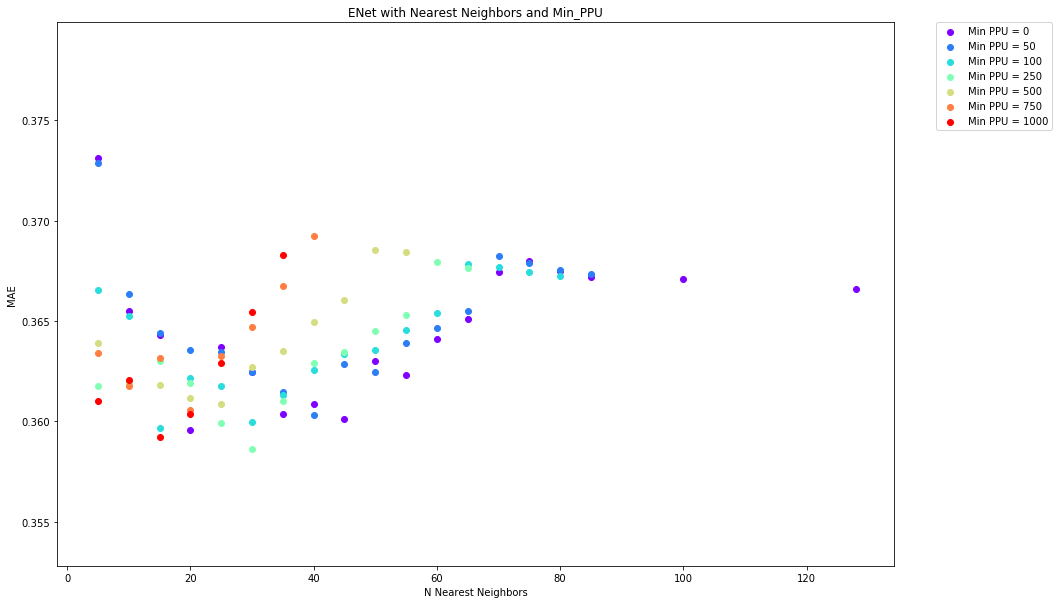

In [158]:
ls = mae_list

size = len(ls) 
idx_list = [idx + 1 for idx, val in enumerate(ls) if val == 0] 
ys = [ls[i: j] for i, j in
        zip([0] + idx_list, idx_list + 
        ([size] if idx_list[-1] != size else []))] 

for i, y in enumerate(ys):
    y = y[:-1]
    ys[i] = y

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

plt.figure(figsize=[15,10])
plt.title("ENet with Nearest Neighbors and Min_PPU")
plt.xlabel("N Nearest Neighbors")
plt.ylabel("MAE")

i = 0
for y, c in zip(ys, colors):
    x = np.linspace(5, 5*len(y), len(y))
    if i == 0:
        x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]
    else:
        x = np.linspace(5, 5*len(y), len(y))
    plt.scatter(x, y, color=c, label="Min PPU = " + str(min_ppu_list[i]))
    i += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [165]:
min_ppu_list = [0, 50, 100, 250, 500, 750, 1000]
n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]



lens = []

for min_ppu in min_ppu_list:
    
    user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
    sub_df = df[df['username'].isin(user_indices)]
    n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

    len0 = []
    for top_n in n_users_list:
        
        # split data 
        top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
        df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
        
        len0.append(len(df_top_n))

    lens.append(len0)


n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]

for i in range(len(ys)):
    min_mae = min(ys[i])
    ind = ys[i].index(min(ys[i]))
    
    min_ppu = min_ppu_list[i]
    n_nn = n_users_list[ind]
    n_points = lens[i][ind]
    
    print("min_ppu = {}, n_nn = {}, n_points = {}, min_mae = {}".format(min_ppu, n_nn, n_points, min_mae))

min_ppu = 0, n_nn = 20, n_points = 15200, min_mae = 0.3595635543991754
min_ppu = 50, n_nn = 40, n_points = 50109, min_mae = 0.3603070312303348
min_ppu = 100, n_nn = 15, n_points = 14625, min_mae = 0.3596762497064684
min_ppu = 250, n_nn = 30, n_points = 43260, min_mae = 0.35861074753210725
min_ppu = 500, n_nn = 25, n_points = 44297, min_mae = 0.36085583268417015
min_ppu = 750, n_nn = 20, n_points = 37973, min_mae = 0.36056679567720823
min_ppu = 1000, n_nn = 15, n_points = 30214, min_mae = 0.35923550893322875


In [164]:
min_ppu_list = [0, 50, 100, 250, 500, 750, 1000]
n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]



lens = []

for min_ppu in min_ppu_list:
    
    user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
    sub_df = df[df['username'].isin(user_indices)]
    n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

    len0 = []
    for top_n in n_users_list:
        
        # split data 
        top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
        df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
        
        len0.append(len(df_top_n))

    lens.append(len0)


n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]


# i is index for min_ppu
for i in range(len(ys)):
    if i == 0 or i == 2:
        # ind is index for n_nn
        y_copy = ys[i].copy()
        y_copy.sort()
        min_mae = y_copy[i]
        ind = ys[i].index(y_copy[1])
        min_ppu = min_ppu_list[i]
        n_nn = n_users_list[ind]
        n_points = lens[i][ind]
    else:
        # ind is index for n_nn
        min_mae = min(ys[i])
        ind = ys[i].index(min(ys[i]))
        min_ppu = min_ppu_list[i]
        n_nn = n_users_list[ind]
        n_points = lens[i][ind]
    
    print("min_ppu = {}, n_nn = {}, n_points = {}, min_mae = {}".format(min_ppu, n_nn, n_points, min_mae))

min_ppu = 0, n_nn = 45, n_points = 51509, min_mae = 0.3595635543991754
min_ppu = 50, n_nn = 40, n_points = 50109, min_mae = 0.3603070312303348
min_ppu = 100, n_nn = 30, n_points = 38085, min_mae = 0.3613313132900574
min_ppu = 250, n_nn = 30, n_points = 43260, min_mae = 0.35861074753210725
min_ppu = 500, n_nn = 25, n_points = 44297, min_mae = 0.36085583268417015
min_ppu = 750, n_nn = 20, n_points = 37973, min_mae = 0.36056679567720823
min_ppu = 1000, n_nn = 15, n_points = 30214, min_mae = 0.35923550893322875


# NLP

In [80]:
from BeerMe.Pipeline import *

In [81]:
df = import_table(db_path='data/beer.db')

In [82]:
# tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 30)
X = vectorizer.fit_transform(df['beer_name'])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)

(102598, 30)

In [84]:
df = outlier_analysis(df)



1. NA Count...
ABV                923
global_rating        0
user_rating       3882
IBU              47035
dtype: int64


2. Finding IQR outliers...
FEATURE ABV
num of outliers = 3,421
% of outliers = 3.33%




In [85]:
df = impute_na(df)

NA Count...
ABV              0
global_rating    0
user_rating      0
IBU              0
dtype: int64


In [86]:
user_of_reference = 'tsharp93'
df = COSINE_STEP(df, user_of_reference)

User of Reference for Cosine Sim = tsharp93
(102598, 41)
(102598, 42)


In [87]:
features = ['ABV', 'IBU', 'global_rating'] + vectorizer.get_feature_names()
target = ['user_rating']
df, X_scaler, y_scaler = transform_features_target(df, features, target) 

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/notebooks/BeerMe/BeerMe/Pipeline.py:210: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  df[features] = X_scaler.transform(df[features])


In [88]:
cols = ['username', 'nearest_neighbor_rank'] + features + target
df = df[cols]

In [89]:
%%time

l1_ratio_space = [.1, .5, .7, .9, .95, .99, 1]
min_ppu_list = [0, 50, 100, 250, 500, 750, 1000]
n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]

rand_state = 10

mae_list = []
quarter_abs_error_list = []
half_abs_error_list = []
    

for min_ppu in min_ppu_list:
    
    print(min_ppu)
    
    user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
    sub_df = df[df['username'].isin(user_indices)]
    n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

    for top_n in n_users_list:
        
        # split data 
        top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
        df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
        X_train = df_top_n[features]
        y_train = df_top_n[target]
        y_train = np.array(y_train).reshape(len(y_train), )

        X_test = df[df['username'] == user_of_reference][features]
        y_test = df[df['username'] == user_of_reference][target]
        y_test = np.array(y_test).reshape(len(y_test), )

        # train
        from sklearn.linear_model import ElasticNetCV
        model = ElasticNetCV(fit_intercept=False, normalize=False, l1_ratio=l1_ratio_space, cv=5, random_state=rand_state)
        model.fit(X_train, y_train)

        # Evaluate model on user's data 
        preds = model.predict(X_test)

        # unscale
        preds_unscaled = y_scaler.inverse_transform(preds)
        y_test_unscaled = y_scaler.inverse_transform(y_test)

        # evaluate results
        results_df = pd.DataFrame([preds_unscaled, y_test_unscaled]).transpose()
        results_df.columns = ['predicted', 'actual']
        results_df['error'] = results_df['predicted'] - results_df['actual']
        results_df['abs_error'] = abs(results_df['error'])

        # Performance Metrics 
        mae = np.mean(results_df['abs_error'])

        quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
        half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
        mae_list.append(mae)

        print('MAE =', np.round(mae,5), 
              'with % within 0.25', 100*len(results_df[results_df['abs_error']<=0.25])/len(results_df), 
              'and % within 0.5', 100*len(results_df[results_df['abs_error']<=0.50])/len(results_df),
              "for n =", top_n, "with alpha =", np.round(model.alpha_, 5), "and l1 ratio = ", model.l1_ratio_)
    
    # add breaks
    quarter_abs_error_list.append(0)
    half_abs_error_list.append(0)
    mae_list.append(0)

0
MAE = 0.37312 with % within 0.25 37.5 and % within 0.5 70.0 for n = 5 with alpha = 0.03956 and l1 ratio =  0.5
MAE = 0.3655 with % within 0.25 37.5 and % within 0.5 75.0 for n = 10 with alpha = 0.05766 and l1 ratio =  0.1
MAE = 0.36432 with % within 0.25 40.0 and % within 0.5 72.5 for n = 15 with alpha = 0.03981 and l1 ratio =  0.1
MAE = 0.35956 with % within 0.25 35.0 and % within 0.5 80.0 for n = 20 with alpha = 0.02019 and l1 ratio =  0.5
MAE = 0.36372 with % within 0.25 37.5 and % within 0.5 70.0 for n = 25 with alpha = 0.01503 and l1 ratio =  1.0
MAE = 0.36245 with % within 0.25 37.5 and % within 0.5 70.0 for n = 30 with alpha = 0.01175 and l1 ratio =  1.0
MAE = 0.36036 with % within 0.25 35.0 and % within 0.5 75.0 for n = 35 with alpha = 0.00913 and l1 ratio =  0.5
MAE = 0.36086 with % within 0.25 37.5 and % within 0.5 72.5 for n = 40 with alpha = 0.00645 and l1 ratio =  1.0
MAE = 0.36012 with % within 0.25 35.0 and % within 0.5 75.0 for n = 45 with alpha = 0.01938 and l1 ratio

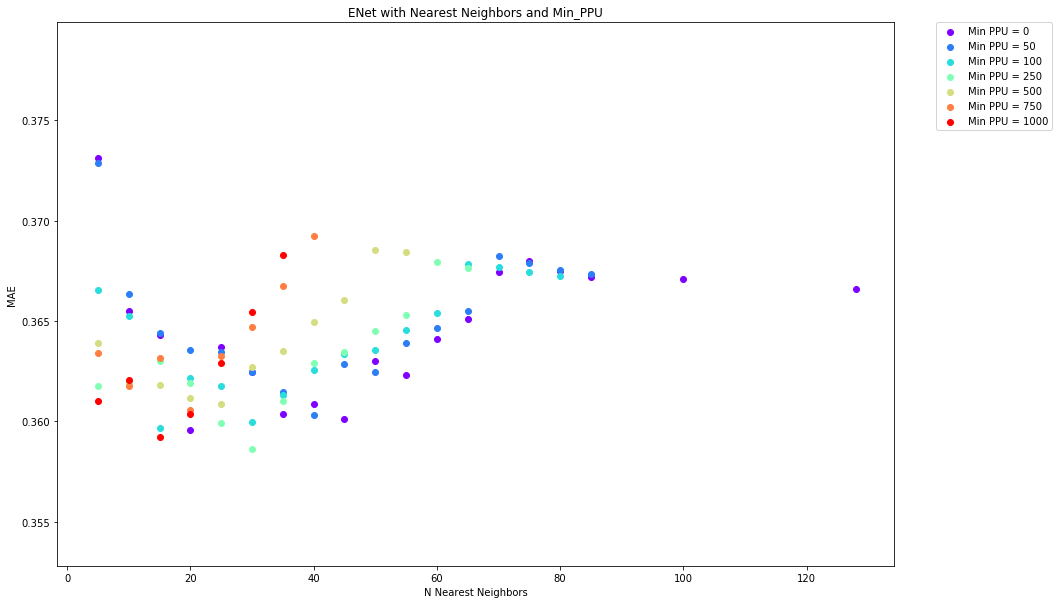

In [90]:
ls = mae_list

size = len(ls) 
idx_list = [idx + 1 for idx, val in enumerate(ls) if val == 0] 
ys = [ls[i: j] for i, j in
        zip([0] + idx_list, idx_list + 
        ([size] if idx_list[-1] != size else []))] 

for i, y in enumerate(ys):
    y = y[:-1]
    ys[i] = y

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

plt.figure(figsize=[15,10])
plt.title("ENet with Nearest Neighbors and Min_PPU")
plt.xlabel("N Nearest Neighbors")
plt.ylabel("MAE")

i = 0
for y, c in zip(ys, colors):
    x = np.linspace(5, 5*len(y), len(y))
    if i == 0:
        x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]
    else:
        x = np.linspace(5, 5*len(y), len(y))
    plt.scatter(x, y, color=c, label="Min PPU = " + str(min_ppu_list[i]))
    i += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [ ]:
min_ppu_list = [0, 50, 100, 250, 500, 750, 1000]
n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]



lens = []

for min_ppu in min_ppu_list:
    
    user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
    sub_df = df[df['username'].isin(user_indices)]
    n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

    len0 = []
    for top_n in n_users_list:
        
        # split data 
        top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
        df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
        
        len0.append(len(df_top_n))

    lens.append(len0)


n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]

for i in range(len(ys)):
    ind = ys[i].index(min(ys[i]))
    
    min_ppu = min_ppu_list[i]
    n_nn = n_users_list[ind]
    n_points = lens[i][ind]
    
    print("min_ppu = {}, n_nn = {}, n_points = {}".format(min_ppu, n_nn, n_points))

## Lasso

In [95]:
%%time

min_ppu_list = [0, 50, 100, 250, 500, 750, 1000]
n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]

rand_state = 10

mae_list = []
quarter_abs_error_list = []
half_abs_error_list = []
    

for min_ppu in min_ppu_list:
    
    print(min_ppu)
    
    user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
    sub_df = df[df['username'].isin(user_indices)]
    n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

    for top_n in n_users_list:
        
        # split data 
        top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
        df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
        X_train = df_top_n[features]
        y_train = df_top_n[target]
        y_train = np.array(y_train).reshape(len(y_train), )

        X_test = df[df['username'] == user_of_reference][features]
        y_test = df[df['username'] == user_of_reference][target]
        y_test = np.array(y_test).reshape(len(y_test), )

        # train
        from sklearn.linear_model import LassoCV
        model = LassoCV(fit_intercept=False, normalize=False, cv=5, random_state=rand_state)
        model.fit(X_train, y_train)

        # Evaluate model on user's data 
        preds = model.predict(X_test)

        # unscale
        preds_unscaled = y_scaler.inverse_transform(preds)
        y_test_unscaled = y_scaler.inverse_transform(y_test)

        # evaluate results
        results_df = pd.DataFrame([preds_unscaled, y_test_unscaled]).transpose()
        results_df.columns = ['predicted', 'actual']
        results_df['error'] = results_df['predicted'] - results_df['actual']
        results_df['abs_error'] = abs(results_df['error'])

        # Performance Metrics 
        mae = np.mean(results_df['abs_error'])

        quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
        half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
        mae_list.append(mae)

        print('MAE =', np.round(mae,5), 
              'with % within 0.25', 100*len(results_df[results_df['abs_error']<=0.25])/len(results_df), 
              'and % within 0.5', 100*len(results_df[results_df['abs_error']<=0.50])/len(results_df),
              "for n =", top_n, "with alpha =", np.round(model.alpha_, 5))
    
    # add breaks
    quarter_abs_error_list.append(0)
    half_abs_error_list.append(0)
    mae_list.append(0)

0
MAE = 0.37203 with % within 0.25 37.5 and % within 0.5 70.0 for n = 5 with alpha = 0.02121
MAE = 0.3655 with % within 0.25 37.5 and % within 0.5 75.0 for n = 10 with alpha = 0.00711
MAE = 0.36415 with % within 0.25 40.0 and % within 0.5 70.0 for n = 15 with alpha = 0.00491
MAE = 0.35943 with % within 0.25 35.0 and % within 0.5 80.0 for n = 20 with alpha = 0.01009
MAE = 0.36372 with % within 0.25 37.5 and % within 0.5 70.0 for n = 25 with alpha = 0.01503
MAE = 0.36245 with % within 0.25 37.5 and % within 0.5 70.0 for n = 30 with alpha = 0.01175
MAE = 0.3603 with % within 0.25 35.0 and % within 0.5 75.0 for n = 35 with alpha = 0.00457
MAE = 0.36086 with % within 0.25 37.5 and % within 0.5 72.5 for n = 40 with alpha = 0.00645
MAE = 0.36028 with % within 0.25 35.0 and % within 0.5 75.0 for n = 45 with alpha = 0.00256
MAE = 0.36304 with % within 0.25 35.0 and % within 0.5 75.0 for n = 50 with alpha = 0.00241
MAE = 0.36232 with % within 0.25 35.0 and % within 0.5 75.0 for n = 55 with alpha

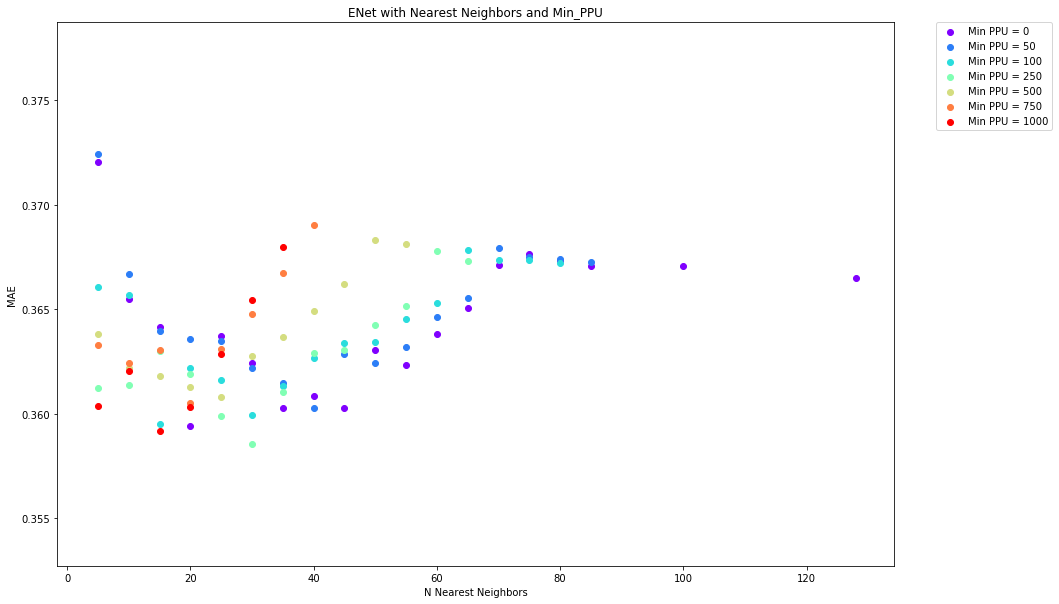

In [96]:
ls = mae_list

size = len(ls) 
idx_list = [idx + 1 for idx, val in enumerate(ls) if val == 0] 
ys = [ls[i: j] for i, j in
        zip([0] + idx_list, idx_list + 
        ([size] if idx_list[-1] != size else []))] 

for i, y in enumerate(ys):
    y = y[:-1]
    ys[i] = y

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

plt.figure(figsize=[15,10])
plt.title("ENet with Nearest Neighbors and Min_PPU")
plt.xlabel("N Nearest Neighbors")
plt.ylabel("MAE")

i = 0
for y, c in zip(ys, colors):
    x = np.linspace(5, 5*len(y), len(y))
    if i == 0:
        x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]
    else:
        x = np.linspace(5, 5*len(y), len(y))
    plt.scatter(x, y, color=c, label="Min PPU = " + str(min_ppu_list[i]))
    i += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
min_ppu_list = [0, 50, 100, 250, 500, 750, 1000]
n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]



lens = []

for min_ppu in min_ppu_list:
    
    user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
    sub_df = df[df['username'].isin(user_indices)]
    n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

    len0 = []
    for top_n in n_users_list:
        
        # split data 
        top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
        df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
        
        len0.append(len(df_top_n))

    lens.append(len0)


n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]

for i in range(len(ys)):
    ind = ys[i].index(min(ys[i]))
    
    min_ppu = min_ppu_list[i]
    n_nn = n_users_list[ind]
    n_points = lens[i][ind]
    
    print("min_ppu = {}, n_nn = {}, n_points = {}".format(min_ppu, n_nn, n_points))